In [5]:
import os
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

In [6]:
Data_Root = '/Data/Promotion/'

In [7]:
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

In [42]:
gens = ['Male', 'Female']
labels = ['Man', 'Woman']

In [9]:
colors = sns.color_palette()[:len(labels)]

In [17]:
reg_data = pd.read_csv(Data_Root+"revision/reg_data_drop_missing.csv", header=0, dtype={'matched_tid': str, 'matched_tid_retweet': str, 'matched_tid_original': str})


In [18]:
len(reg_data)

14552304

In [19]:
reg_data.head(n=3)

,doi,pub_year,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,matched_tid_original,self_promotion_retweet,...,author_eth_ethnea_broad,pub_date,is_active_on_twitter,follower_cn_snapshot,matched_uid,is_active_on_twitter_ours,follower_cn_snapshot_ours,is_active_on_twitter_combine,follower_cn_snapshot_combine,self_promotion_first
0,10.4202/app.00261.2016,2016,Michal Zaton,2,last_position,2064717215,864159182,False,NaN,False,...,EasternEuropean,2016-01-01,False,-1,NaN,False,-1,False,-1,False
1,10.1016/j.foodchem.2013.11.152,2014,Hee-Woong Kim,2,middle_position,2099457132,165507594,False,NaN,False,...,unknown,2014-06-01,False,-1,NaN,False,-1,False,-1,False
2,10.1016/j.foodchem.2013.11.152,2014,Deug-Chan Lee,4,middle_position,2322741405,165507594,False,NaN,False,...,unknown,2014-06-01,False,-1,NaN,False,-1,False,-1,False


In [20]:
reg_data.gender.value_counts()

Male       7386241
Female     4033798
Unknown    2322008
Unisex      810257
Name: gender, dtype: int64

In [21]:
reg_data.gender.value_counts()/len(reg_data)

Male       0.507565
Female     0.277193
Unknown    0.159563
Unisex     0.055679
Name: gender, dtype: float64

### Exclude unisex and unknown

In [22]:
reg_data = reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])]
reg_data.index = range(len(reg_data))

### Exclude unknown affiliation locations

In [24]:
len(reg_data.loc[reg_data.affiliation_cate == 'unknown'])

23287

In [25]:
reg_data = reg_data.loc[reg_data.affiliation_cate != 'unknown']
reg_data.index = range(len(reg_data))

In [26]:
len(reg_data)

11396752

In [38]:
dois_ = set(reg_data.doi)

In [39]:
len(dois_)

2834829

In [40]:
i = 0

with open(Data_Root+'revision/papers_2013_2018.json', 'r') as ifile:
    for line in ifile:
        res = json.loads(line)
        if res['doi'] in dois_:
            i += len(res['data']['tweets'])

In [41]:
# total num of tweet mentions
print(i)

23066929


### Paper-level analysis in raw data

In [85]:
# original and retweets
tid_name = {}

with open(Data_Root+'tweets_v2.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid = line['id_str']
        tid_name[tid] = line['user']['name']
        
with open(Data_Root+'tweets_v2_non_full_text.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid = line['id_str']
        tid_name[tid] = line['user']['name']

In [86]:
len(tid_name)

77497304

In [92]:
dois = set(reg_data.doi)

doi_tids = {}
with open(Data_Root+'revision/papers_2013_2018.json', 'r') as ifile:
    for line in ifile:
        res = json.loads(line)
        if res['doi'] in dois:
            doi_tids[res['doi']] = [tweet['tweet_id'] for tweet in res['data']['tweets'] if tweet['tweet_id'] in tid_name]
del dois

In [93]:
len(doi_tids)

2834829

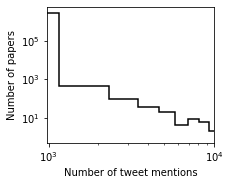

In [94]:
fig, ax = plt.subplots(figsize = (3, 2.5))

ax.hist([len(doi_tids[doi]) for doi in doi_tids], bins = 30, color='k', alpha=1, linewidth=1.5, histtype='step')
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of tweet mentions')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(right=1e4)
# legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('./paper_tweets_hist.pdf', bbox_inches='tight', pad_inches=0.02)

Popularity

In [95]:
doi_frac_self_promo = []
for doi, sub_df in reg_data.groupby('doi'):
    total = len(doi_tids[doi])
    if total > 0:
        promo_users = set([tid_name[str(tid)] for tid in sub_df.loc[sub_df.self_promotion == True]['matched_tid']])
        num_self_promo = 0
        for tid in doi_tids[doi]:
            if tid_name[tid] in promo_users:
                num_self_promo += 1
        doi_frac_self_promo.append((doi, total, num_self_promo))

In [96]:
len(doi_frac_self_promo)

2046732

In [97]:
np.mean([num_self_promo/total for doi, total, num_self_promo in doi_frac_self_promo if total > 0])

0.04367299188803496

In [98]:
for i in range(0, 101, 10):
    tem = []
    for doi, total, num_self_promo in doi_frac_self_promo:
        if total > i and total <= (i+10):
            tem.append(num_self_promo/total)
    print("%d < x <= %d"%(i, i+10), np.mean(tem), np.median(tem))

0 < x <= 10 0.042127076550066006 0.0
10 < x <= 20 0.055990710812375985 0.0
20 < x <= 30 0.053717550649167084 0.0
30 < x <= 40 0.051178454860133525 0.02631578947368421
40 < x <= 50 0.04806262710830598 0.021739130434782608
50 < x <= 60 0.04523749933032134 0.018518518518518517
60 < x <= 70 0.04237157211533122 0.015873015873015872
70 < x <= 80 0.04286691107962363 0.013888888888888888
80 < x <= 90 0.04117621429600945 0.022222222222222223
90 < x <= 100 0.038804285951398475 0.020202020202020204
100 < x <= 110 0.040295779149073604 0.018691588785046728


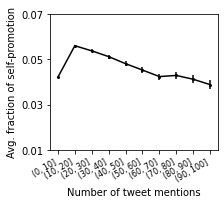

In [104]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3, 2.5))


xs, ys, confs = [], [], []

step = 10
for i in range(0, 91, step):
    xs.append(i)
    tem = []
    for doi, total, num_self_promo in doi_frac_self_promo:
        if total > i and total <= (i+step):
            tem.append(num_self_promo/total)
    ys.append(np.mean(tem))
    confs.append(CIs['95'] * np.std(tem) / np.sqrt(len(tem)))
                    
ax.errorbar(xs, ys, yerr=confs, color='k', fmt='-o', markersize=2, linewidth=1.5)
ax.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
ax.set_xticks(xs)
ax.set_xticklabels(['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_xlabel('Number of tweet mentions')
ax.set_ylabel('Avg. fraction of self-promotion')
ax.set_ylim([0.01, 0.07])

# plt.tight_layout()
plt.show()
fig.savefig('./avg_perc_promo_paper_tweets.pdf', bbox_inches='tight', pad_inches=0.01)


Discipline

In [100]:
name_map = {'Social Sciences': 'Social_Sciences',
            'Life Sciences': 'Life_Sciences',
            'Health Sciences': 'Health_Sciences',
            'Physical Sciences': 'Physical_Sciences'}

In [101]:
xs, ys, confs = [], [], []
for disc in name_map:
    tem = []
    dois_ = set(reg_data.loc[reg_data[name_map[disc]] == 1]['doi'])
    for doi, total, num_self_promo in doi_frac_self_promo:
        if doi in dois_:
            tem.append(num_self_promo/total)
    xs.append(np.mean(tem))
    ys.append(disc)
    confs.append(CIs['95'] * np.std(tem) / np.sqrt(len(tem)))

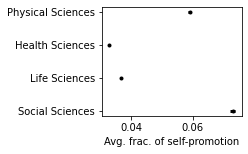

In [102]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5, 2))
ax.errorbar(xs, ys, xerr=confs, color='k', alpha=1, fmt='o', markersize=3, linewidth=3)
ax.set_xlabel('Avg. frac. of self-promotion')
plt.show()
fig.savefig('./avg_perc_promo_paper_disc.pdf', bbox_inches='tight', pad_inches=0.01)

### Author-level analysis in raw data

In [43]:
len(set(reg_data.author_id))

3503674

In [44]:
tem = dict(Counter(dict(zip(reg_data['author_id'], reg_data['gender'])).values()))

In [45]:
tem

{'Male': 2029762, 'Female': 1473912}

In [46]:
# Frac of males
tem['Male'] / (tem['Male'] + tem['Female'])

0.5793238754518828

In [47]:
tem['Female'] / (tem['Male'] + tem['Female'])

0.4206761245481172

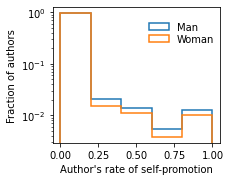

In [44]:
fig, ax = plt.subplots(figsize = (3, 2.5))

for lab, gender, color in zip(labels, gens, colors):
    sub_df = reg_data.loc[reg_data['gender'] == gender, ['author_id', 'author_self_promotion_rate']]
    sub_df = sub_df.drop_duplicates()
    n = len(sub_df)
    ax.hist(sub_df['author_self_promotion_rate'].tolist(), bins = 5, alpha=1, linewidth=1.5, \
            color=color, label=lab, histtype='step', weights=np.ones(n)/n)
# ax.set_ylabel('Number of authors')
ax.set_ylabel('Fraction of authors')
ax.set_xlabel("Author's rate of self-promotion")
ax.set_yscale('log')
legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('gender_rate_hist_all_authors.pdf', bbox_inches='tight', pad_inches=0.02)

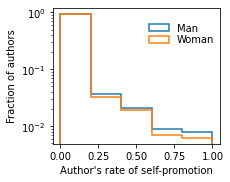

In [45]:
fig, ax = plt.subplots(figsize = (3, 2.5))

for lab, gender, color in zip(labels, gens, colors):
    mask = (reg_data['gender'] == gender) & (reg_data['author_num_papers_in_data'] >= 5)
    sub_df = reg_data.loc[mask, ['author_id', 'author_self_promotion_rate']]
    sub_df = sub_df.drop_duplicates()
    n = len(sub_df)
    ax.hist(sub_df['author_self_promotion_rate'].tolist(), bins = 5, alpha=1, linewidth=1.5, \
            color=color, label=lab, histtype='step', weights=np.ones(n)/n)
# ax.set_ylabel('Number of authors')
ax.set_ylabel('Fraction of authors')
ax.set_xlabel("Author's rate of self-promotion")
ax.set_yscale('log')
legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('gender_rate_hist_authors_5.pdf', bbox_inches='tight', pad_inches=0.02)

### (paper, author) level

In [52]:
reg_data.gender.value_counts()/len(reg_data)

Male      0.646772
Female    0.353228
Name: gender, dtype: float64

In [53]:
np.mean(reg_data.self_promotion)

0.042171839836472706

In [54]:
for gender, group in reg_data.groupby('gender'):
    print(gender, np.mean(group.self_promotion))

Female 0.03473749580813036
Male 0.04623202880654752


Author position

In [46]:
name_pos = {'first_position': 'First Position', 'middle_position': 'Middle Position', 'last_position': 'Last Position'}


In [50]:
means = [[], []]
confs = [[], []]
aut_pos = []
for pos, subgp in reg_data.groupby('authorship_pos'):
    if pos != 'solo_author':
        aut_pos.append(pos)
        for i, gen in enumerate(gens):
            gp = subgp.loc[subgp.gender==gen]
            means[i].append(np.mean(gp['self_promotion']) * 100)
            sigma = np.std(gp['self_promotion']) * 100
            confs[i].append(CIs['95']*(sigma/np.sqrt(len(gp))))

In [51]:
means

[[7.464804377192448, 5.846980253665916, 3.4033408154695035],
 [5.8880009036739995, 4.982378943618129, 2.2634595327906073]]

In [52]:
for i in range(3):
    a = means[0][i]
    b = means[1][i]
    print((a-b)/b)

0.2677994618741572
0.17353182482340984
0.5036013527812192


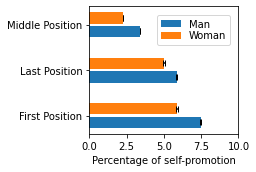

In [53]:
step = 4
ys_1 = 0.9 + np.arange(3) * step
ys_2 = 2.1 + np.arange(3) * step
y_pos = 1.5 + np.arange(3) * step

fig, ax = plt.subplots(figsize = (3.6, 2.5))

ax.barh(ys_1, width = means[0], height=1, xerr = confs[0], alpha = 1.0, capsize = 3, color=colors[0], label='Man')
ax.barh(ys_2, width = means[1], height=1, xerr = confs[1], alpha = 1.0, capsize = 3, color=colors[1], label='Woman')

legend = ax.legend(loc=[0.45, 0.7], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
ax.set_yticks(y_pos)
ax.set_yticklabels([name_pos[pos] for pos in aut_pos], rotation=0, ha='right')
ax.set_xlabel('Percentage of self-promotion')
ax.set_xlim([0, 10])
plt.tight_layout()
plt.show()
fig.savefig('./perc_promo_gender_pos.pdf', bbox_inches='tight', pad_inches=0.02)


Discipline

In [54]:
name_map = {'Social Sciences': 'Social_Sciences',
            'Life Sciences': 'Life_Sciences',
            'Health Sciences': 'Health_Sciences',
            'Physical Sciences': 'Physical_Sciences'}

In [55]:
for disc in name_map.values():
    sub_df = reg_data.loc[reg_data[disc] == 1]
    print(disc, np.mean(sub_df.self_promotion))

Social_Sciences 0.07824941768713913
Life_Sciences 0.03554151987445492
Health_Sciences 0.03386756643618453
Physical_Sciences 0.03339868393109221


In [56]:
means = [[], []]
confs = [[], []]
for disc in name_map:
    subgp = reg_data.loc[reg_data[name_map[disc]] == 1]
    for i, gen in enumerate(gens):
        gp = subgp.loc[subgp.gender==gen]
        means[i].append(np.mean(gp['self_promotion']) * 100)
        sigma = np.std(gp['self_promotion']) * 100
        confs[i].append(CIs['95']*(sigma/np.sqrt(len(gp))))

In [57]:
means

[[8.396830631443747, 4.170143540968367, 3.747922218847165, 3.456138624438304],
 [7.056924497900696,
  2.5407740739434024,
  2.8196011668102687,
  3.0057598930586407]]

In [58]:
for i in range(4):
    a = means[0][i]
    b = means[1][i]
    print((a-b)/b)

0.18987111650998215
0.6412886071747835
0.32923842668396897
0.14983855910106011


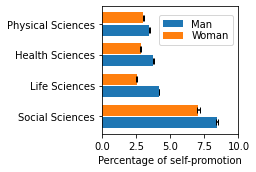

In [59]:
step = 2.5
ys_1 = 1 + np.arange(4) * step
ys_2 = 2 + np.arange(4) * step
y_pos = 1.5 + np.arange(4) * step

fig, ax = plt.subplots(figsize = (3.6, 2.5))

ax.barh(ys_1, width = means[0], height=0.9, xerr = confs[0], alpha = 1.0, capsize = 3, color=colors[0], label='Man')
ax.barh(ys_2, width = means[1], height=0.9, xerr = confs[1], alpha = 1.0, capsize = 3, color=colors[1], label='Woman')

legend = ax.legend(loc=[0.42, 0.7], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
ax.set_yticks(y_pos)
ax.set_yticklabels([disc for disc in name_map], rotation=0, ha='right')
ax.set_xlabel('Percentage of self-promotion')
ax.set_xlim([0, 10])
plt.tight_layout()
plt.show()
fig.savefig('./perc_promo_gender_disc.pdf', bbox_inches='tight', pad_inches=0.02)

By year

In [60]:
gender_y_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['pub_year', 'self_promotion']]
    for year, sub_df in tem.groupby('pub_year'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_y_rate[gender][year] = (mu, std, n)

In [61]:
gender_y_rate

{'Male': {2013: (0.02017481037794199, 0.14059796372691913, 983008),
  2014: (0.026914707181600273, 0.16183419205757782, 1104712),
  2015: (0.03575409338209638, 0.18567643412269833, 1238096),
  2016: (0.04390702576006032, 0.20488825942197314, 1320882),
  2017: (0.058158548230234114, 0.23404301206826417, 1358287),
  2018: (0.08048871363140932, 0.27204830565429056, 1366117)},
 'Female': {2013: (0.01220630626977829, 0.10980579382266972, 517929),
  2014: (0.017476197835128434, 0.13103732424143846, 595324),
  2015: (0.02447975462428289, 0.15453315578806312, 691837),
  2016: (0.031770222585426736, 0.17538778618335768, 742771),
  2017: (0.045048333352957104, 0.2074101757751484, 764379),
  2018: (0.06748854095120618, 0.2508661750644824, 713410)}}

In [62]:
for y in list(range(2013, 2019)):
    a = gender_y_rate['Male'][y][0]
    b = gender_y_rate['Female'][y][0]
    print(y, (a-b)/b)

2013 0.6528186276869847
2014 0.5400779640694926
2015 0.4605576702402819
2016 0.382018197763614
2017 0.2910255252854192
2018 0.19262785203197952


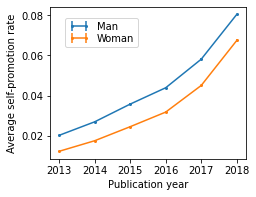

In [63]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    xs = list(range(2013, 2019))
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_y_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)

legend = ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
ax.set_xlabel('Publication year')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_year_raw.pdf', bbox_inches='tight', pad_inches=0.01)


In [52]:
for year, gp in reg_data.loc[reg_data['is_active_on_twitter'] == True].groupby('pub_year'):
    print(year, np.mean(gp['self_promotion']))

2013 0.354429876837505
2014 0.369352674292287
2015 0.3842091705306543
2016 0.39092126212187
2017 0.4341819550792936
2018 0.477156755210072


By journal impact

In [64]:
gender_jif_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['journal_impact', 'self_promotion']]
    # tem = tem.dropna()
    tem['jif_bin'] = tem['journal_impact'].apply(lambda x: int(x//5))
    tem['jif_bin'] = tem['jif_bin'].apply(lambda x: x if x <= 8 else 9)
    for jif, sub_df in tem.groupby('jif_bin'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_jif_rate[gender][jif] = (mu, std, n)

In [65]:
gender_jif_rate

{'Male': {0: (0.03960319826621017, 0.19502508800997237, 5027599),
  1: (0.047001103303449844, 0.21164120485318616, 1594303),
  2: (0.07634592943684901, 0.26555080209871834, 347065),
  3: (0.06374213661415132, 0.24429301388704136, 125741),
  4: (0.09832948526415863, 0.2977596305610354, 66267),
  5: (0.059756388280301054, 0.23703493907016102, 88091),
  6: (0.09879891514916699, 0.29839183888725024, 15486),
  7: (0.12523350234455416, 0.33098349239058844, 26231),
  8: (0.18241516399261679, 0.38618631764753586, 56344),
  9: (0.223274244004171, 0.4164406992220344, 23975)},
 'Female': {0: (0.03268474301229658, 0.17781015321549196, 2888932),
  1: (0.033202761158268125, 0.17916567140424838, 778369),
  2: (0.049151412292399076, 0.21618406731778753, 164980),
  3: (0.03747859824387792, 0.18993144267748802, 63663),
  4: (0.07107818261781522, 0.25695539413206275, 29559),
  5: (0.03029492271913396, 0.1713976090165078, 48589),
  6: (0.06954397394136808, 0.25437690467062923, 6140),
  7: (0.0669930640554

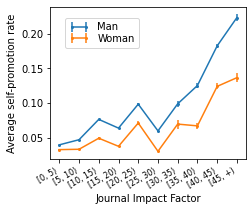

In [66]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    xs = list(range(10))
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_jif_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
# ax.margins(0,0)
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)', '[30, 35)', '[35, 40)', \
                    '[40, 45)', '[45, +)'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_xlabel('Journal Impact Factor')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_jif_raw.pdf', bbox_inches='tight', pad_inches=0.01)

By affiliation rank

In [67]:
gender_affi_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['affiliation_rank_cate', 'self_promotion']]
    # tem = tem.dropna()
    # tem['affi_bin'] = tem['affiliation_rank'].apply(lambda x: int(x//2000))
    for affi, sub_df in tem.groupby('affiliation_rank_cate'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_affi_rate[gender][affi] = (mu, std, n)

In [68]:
gender_affi_rate

{'Male': {0.0: (0.06192244403896991, 0.24101463640868484, 781526),
  1.0: (0.05633711964928807, 0.2305715693638526, 821643),
  2.0: (0.04469021075738475, 0.20662283470092377, 800399),
  3.0: (0.05011821425723113, 0.21818886052431138, 777402),
  4.0: (0.04272879730125758, 0.202245017694987, 774583),
  5.0: (0.04520512940284277, 0.20775376212842697, 727882),
  6.0: (0.03938829542891983, 0.19451698540776324, 718386),
  7.0: (0.034215424479932414, 0.18178209264828712, 669961),
  8.0: (0.039655973393470816, 0.19514962763911992, 650066),
  9.0: (0.04369168307010816, 0.20440821876971918, 649254)},
 'Female': {0.0: (0.04304108082189849, 0.20294961488897015, 425454),
  1.0: (0.045412259161314694, 0.2082065942259761, 423520),
  2.0: (0.034949681870623577, 0.1836523934169272, 437715),
  3.0: (0.04211136486896641, 0.2008432170072945, 401958),
  4.0: (0.031871037855460964, 0.17565669586291535, 414075),
  5.0: (0.03377488708579492, 0.18064922941473274, 402518),
  6.0: (0.030451883276368445, 0.171827

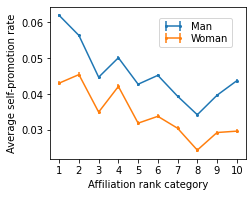

In [69]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_affi_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.53, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
# ax.margins(0,0)
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticks(xs)
ax.set_xticklabels(list(range(1, 11)))
# for tick in ax.get_xticklabels():
#     tick.set_ha('right')
#     tick.set_fontsize(8)
#     tick.set_rotation(30)
ax.set_xlabel('Affiliation rank category')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_affi_raw.pdf', bbox_inches='tight', pad_inches=0.01)


By previous num. publications

In [70]:
gender_pub_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['author_pub_count_cate', 'self_promotion']]
    # tem = tem.dropna()
    # tem['pub_bin'] = tem['author_pub_count'].apply(lambda x: int(x//10))
    for pub, sub_df in tem.groupby('author_pub_count_cate'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_pub_rate[gender][pub] = (mu, std, n)

In [71]:
gender_pub_rate

{'Male': {0.0: (0.02420530476792262, 0.15368606959973502, 401978),
  1.0: (0.034062262481360704, 0.18138915280691842, 448649),
  2.0: (0.04053287919814202, 0.19720538760908854, 456839),
  3.0: (0.04683624344327082, 0.21128797822733197, 695850),
  4.0: (0.052593923688379784, 0.22322142119304023, 658327),
  5.0: (0.05555466330301185, 0.2290596924129185, 809437),
  6.0: (0.05483019691410214, 0.22764851508512615, 838589),
  7.0: (0.0511002828613892, 0.2202022796268813, 917764),
  8.0: (0.04626174606913726, 0.2100514149435131, 1010338),
  9.0: (0.04010390609627726, 0.19620291234356907, 1133331)},
 'Female': {0.0: (0.017285923765041778, 0.13033464851922894, 386673),
  1.0: (0.024666470102876002, 0.15510652905516237, 437517),
  2.0: (0.029919444883719816, 0.17036511292389023, 417354),
  3.0: (0.03534322574963674, 0.1846458289354162, 567775),
  4.0: (0.04090790955557481, 0.1980768853030755, 461720),
  5.0: (0.043678804274593946, 0.20437946651201447, 482385),
  6.0: (0.04242458068022985, 0.2015

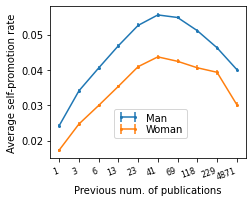

In [72]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

# xs = np.arange(0, 101, 10)
xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_pub_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.3, 0.1), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
ax.set_xticks(xs)
ax.set_xticklabels([1, 3, 6, 13, 23, 41, 69, 118, 229, 4871])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(20)
ax.set_xlabel('Previous num. of publications')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_pub_raw.pdf', bbox_inches='tight', pad_inches=0.01)


By previous num. publications (active subset)

Note: the relationship among this subset is more linear, instead of quadratic.

In [73]:
gender_pub_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[(reg_data['is_active_on_twitter'] == True) & (reg_data.gender==gender), ['author_pub_count_cate', 'self_promotion']]
    # tem = tem.dropna()
    for pub, sub_df in tem.groupby('author_pub_count_cate'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_pub_rate[gender][pub] = (mu, std, n)

In [74]:
gender_pub_rate

{'Male': {0.0: (0.6525183927560838, 0.4761702845318059, 1767),
  1.0: (0.6317439366441181, 0.4823313541099216, 6061),
  2.0: (0.5980604381331717, 0.49028986372668415, 11549),
  3.0: (0.5668829964769145, 0.49550647299734546, 26965),
  4.0: (0.5316604587335817, 0.4989966085583941, 35707),
  5.0: (0.5021341920023963, 0.4999954452037508, 53416),
  6.0: (0.4643520479650689, 0.49872760452547166, 61378),
  7.0: (0.42304178208344817, 0.49404193414639264, 68953),
  8.0: (0.36522173034110395, 0.4814922824176457, 78158),
  9.0: (0.2865996556894541, 0.4521728574872009, 90035)},
 'Female': {0.0: (0.6237148732008225, 0.48445291840271165, 1459),
  1.0: (0.6339389253962119, 0.4817264413167582, 5174),
  2.0: (0.5767431499220317, 0.4940753879116471, 8978),
  3.0: (0.5420743639921722, 0.49822660295758414, 19418),
  4.0: (0.4996979373435747, 0.4999999087581433, 23174),
  5.0: (0.45729273201148096, 0.498172750419929, 30311),
  6.0: (0.4099634210067932, 0.49182661014141976, 28705),
  7.0: (0.361538177930169

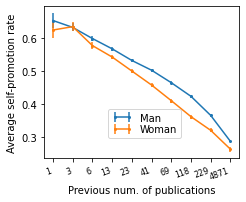

In [75]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

# xs = np.arange(0, 101, 10)
xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_pub_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.3, 0.1), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
ax.set_xticks(xs)
ax.set_xticklabels([1, 3, 6, 13, 23, 41, 69, 118, 229, 4871])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(20)
ax.set_xlabel('Previous num. of publications')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_pub_active_sub_raw.pdf', bbox_inches='tight', pad_inches=0.01)
